In [1]:
import re
from datetime import datetime
from os import path

import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
recordings_dir = '../recordings'
recording_name = '12Feb2024'
log_file_name = 'command line output.txt'

# path.join combines the parts of the file path
# path.abspath normalizes all slashes and provides the full absolute path
log_file = path.abspath(path.join(recordings_dir, recording_name, log_file_name))

print(f'Reading log file: {log_file}')

Reading log file: c:\Users\derek\Source\kiwi_tracker\recordings\12Feb2024\command line output.txt


In [3]:
# Initialize arrays to store data
dates = []
bpms = []
snrs = []
beep_durations = []

# Define the regular expression pattern to extract data
pattern = re.compile(r'  DATE : (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+) \| BPM :  (\d+\.\d+) \|  SNR :  (\d+\.\d+)  \| BEEP_DURATION :  (\d+\.\d+) sec.*')

# Read the log file
with open(log_file, 'r') as file:
    # Process each line
    for line in file:
        # Match the pattern in each line
        match = pattern.match(line)
        if match:
            # Extract data from the matched groups
            date_str, bpm_str, snr_str, beep_duration_str = match.groups()

            # Convert strings to appropriate data types
            date = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f')
            bpm = float(bpm_str)
            snr = float(snr_str)
            beep_duration = float(beep_duration_str)

            # Append data to arrays
            dates.append(date)
            bpms.append(bpm)
            snrs.append(snr)
            beep_durations.append(beep_duration)

print(f'Read {len(bpms)} beeps from the record')

Read 597 beeps from the record


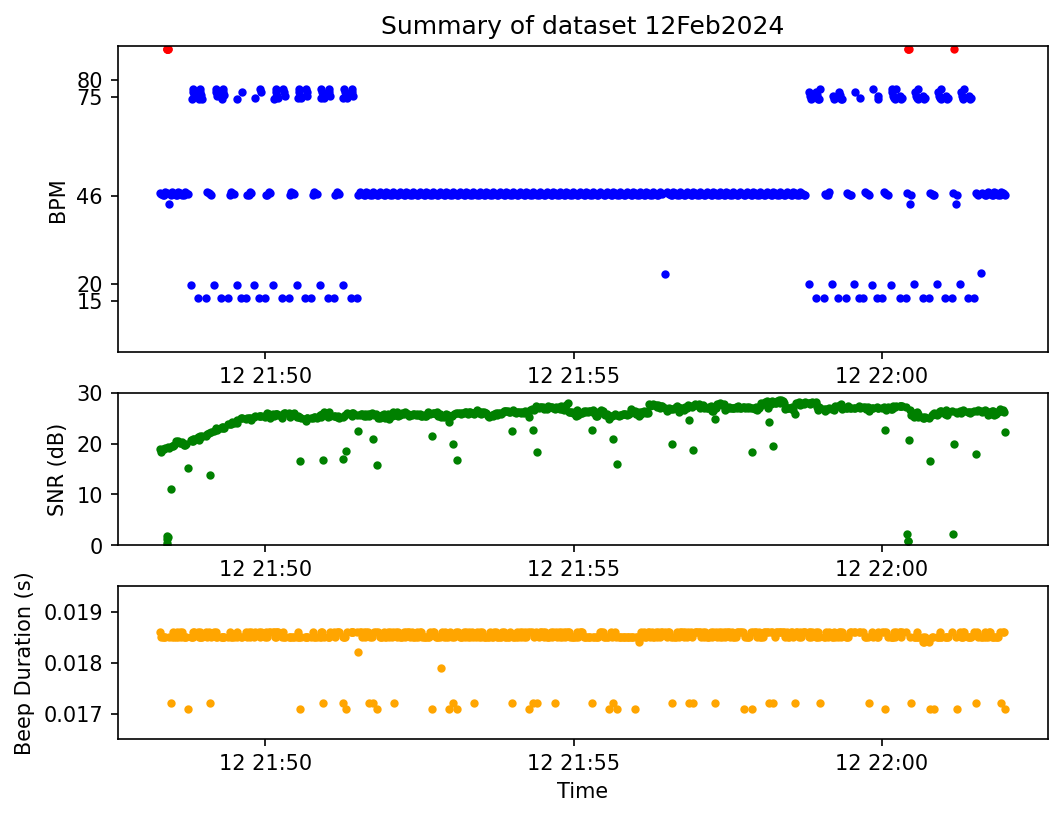

In [4]:
# Config
marker = '.' # 'o'
linewidth = 0.0

fig, axes = plt.subplots(3, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [2, 1, 1]}, dpi=150)
axes[0].set_title(f'Summary of dataset {recording_name}')

axes[0].plot(dates, bpms, label='BPMs', marker=marker, lw=linewidth, color='blue')

# Find and plot points off the chart
high_bpm_dates = [date for date, bpm in zip(dates, bpms) if bpm > 90]
axes[0].plot(high_bpm_dates, [89]*len(high_bpm_dates), label='Errors', marker=marker, lw=linewidth, color='red')


axes[0].set_ylabel("BPM")
axes[0].set_ylim([0, 90])
axes[0].set_yticks([15, 20, 46, 75, 80])

axes[1].plot(dates, snrs, label='SNRs', marker=marker, lw=linewidth, color='green')
axes[1].set_ylabel("SNR (dB)")
axes[1].set_ylim([0, 30])

axes[2].plot(dates, beep_durations, label='Beep Durations', marker=marker, lw=linewidth, color='orange')
axes[2].set_ylabel("Beep Duration (s)")
axes[2].set_ylim([0.0165, 0.0195])
axes[2].set_xlabel('Time')

#plt.grid(True)
#plt.show()

fig.savefig(path.abspath(path.join(recordings_dir, recording_name, f'{recording_name}_plots.pdf')), format='pdf', bbox_inches='tight')
fig.savefig(path.abspath(path.join(recordings_dir, recording_name, f'{recording_name}_plots.png')), format='png', bbox_inches='tight')

In [5]:
signal = np.fromfile(path.abspath(path.join(recordings_dir, recording_name, 'testing_gain.fc32')), 'complex64')
t0 = np.datetime64(dates[0])
fs = 10240

In [6]:
mag_samples = np.abs(signal)
match_filtered = sp.signal.convolve(mag_samples, [1]*185, 'valid')
peaks = sp.signal.find_peaks(match_filtered, prominence=2)[0]
pulse_intervals = [(peak2 - peak1) / fs for (peak1, peak2) in zip(peaks[:-1], peaks[1:])]
bpms2 = [60 / interval for interval in pulse_intervals]
pulse_intervals = [i * 1000 for i in pulse_intervals]
print(len(bpms))
print(len(bpms2))
print(pulse_intervals[0:10])
print(bpms2[0:10])

597
593
[1287.59765625, 1297.55859375, 1307.03125, 1307.6171875, 1277.44140625, 1287.6953125, 1297.0703125, 1307.6171875, 1306.93359375, 1277.63671875]
[46.59840728100114, 46.24068638518853, 45.90555887627017, 45.884988797610156, 46.968886170782056, 46.59487335052329, 46.25809366059328, 45.884988797610156, 45.908989015915715, 46.9617060307269]


In [7]:
valid_intervals = [250, 750, 1250, 1750, 2000, 3000, 3750]

telemetry_intervals = [interval - min(valid_intervals, key=lambda x:abs(x-interval)) for interval in pulse_intervals]
for interval in telemetry_intervals[150:170]:
    print(f'{interval:.2f}', end=' ')

37.50 47.56 57.13 57.62 27.44 37.70 47.17 57.42 57.23 27.54 37.50 47.66 57.03 57.62 27.44 37.21 47.46 57.71 57.03 27.64 

In [14]:
fast_telemetry = dict({
    0 : "0",
    10: "Mortality",
    20: "1",
    30: "2",
    40: "Nesting",
    50: "3",
    60: "4",
    70: "Not Nesting",
    80: "5",
    90: "6",
    100: "Hatch",
    110: "7",
    120: "8",
    130: "Deserting",
    140: "9"
})

counter = 0
for interval in telemetry_intervals[:10]:
    print(fast_telemetry[min(fast_telemetry, key=lambda x:abs(x-interval))], end=' ')
    if counter == 4:
        print("")
        counter = 0
    else:
        counter += 1


Nesting 3 4 4 2 
Nesting 3 4 4 2 


In [9]:
fs = 10240
x = signal[fs*0:fs*120]
NFFT = 512
w = np.blackman(NFFT)
f = np.fft.fftshift(np.abs(np.fft.fft(w * x[:x.size//NFFT*NFFT].reshape(-1, NFFT)))**2, axes=1)
tf = t0 + (NFFT / fs * 1e9) * np.arange(f.shape[0]) * np.timedelta64(1, 'ns')
faxis = np.fft.fftshift(np.fft.fftfreq(NFFT, 1/fs))

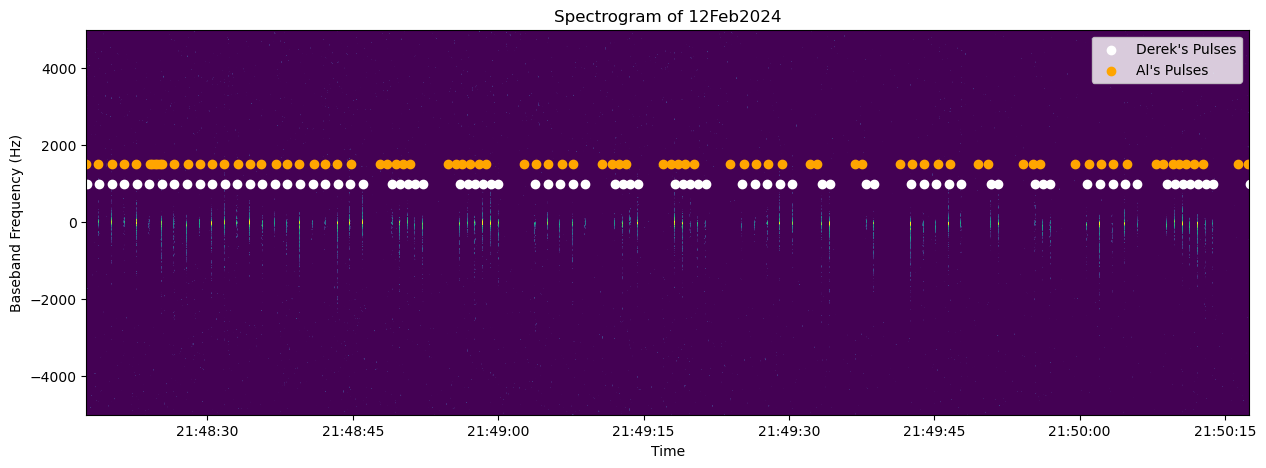

In [10]:
fsel = (faxis >= -5000) & (faxis <= 5000)
#fsel = (faxis > -10000)
plt.figure(figsize=(15, 5))
plt.imshow(10*np.log10(f[:, fsel]).T[::-1], aspect='auto', vmin=-5, vmax=10,
           extent=[tf[0], tf[-1], faxis[fsel][0], faxis[fsel][-1]])
plt.xlabel('Time')
plt.ylabel('Baseband Frequency (Hz)')
plt.title(f'Spectrogram of {recording_name}');

peak_ffts = peaks/NFFT
peak_indexs = t0 + (NFFT / fs * 1e9) * peak_ffts * np.timedelta64(1, 'ns')
l1 = plt.scatter(peak_indexs, [1000]*len(peak_indexs), c='white', marker='o')
l2 = plt.scatter(dates, [1500]*len(dates), c='orange', marker='o')

plt.legend((l1, l2), ("Derek's Pulses", "Al's Pulses"))

plt.savefig(path.abspath(path.join(recordings_dir, recording_name, f'{recording_name}_spectrogram.png')), format='png', bbox_inches='tight')

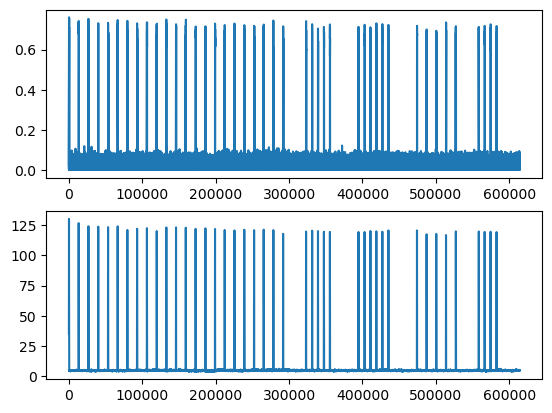

In [11]:
fig, axes = plt.subplots(2,1)
ax = axes[0]
ax.plot(mag_samples[:fs*60])

ax = axes[1]
ax.plot(match_filtered[:fs*60])
#ax.scatter(peaks, match_filtered[peaks], marker='o', color='orange')

In [22]:
print(["{:.2f}".format(bpm) for bpm in bpms2])

valid_intervals = [250, 750, 1250, 1750, 2000, 3000, 3750]
valid_BPMs = [60 / (interval / 1000) for interval in valid_intervals]

normalized_BPMs = [min(valid_BPMs, key=lambda x:abs(x-bpm)) for bpm in bpms2]

print(valid_BPMs)

extended_intervals = [interval + increase for increase in fast_telemetry.keys() for interval in valid_intervals[1:]]
extended_BPMs = [60 / (interval / 1000) for interval in extended_intervals]

['46.60', '46.24', '45.91', '45.88', '46.97', '46.59', '46.26', '45.88', '45.91', '46.96', '46.60', '46.24', '45.90', '45.89', '46.97', '46.61', '46.25', '45.88', '45.96', '46.96', '46.60', '46.24', '19.65', '74.20', '77.14', '76.07', '75.15', '15.78', '74.21', '77.07', '76.10', '75.18', '74.21', '15.78', '46.97', '46.59', '46.25', '45.90', '19.65', '77.12', '76.09', '75.17', '15.78', '74.22', '77.05', '76.11', '75.18', '15.78', '45.90', '46.97', '46.59', '46.26', '19.65', '74.20', '15.91', '76.10', '15.82', '45.88', '45.88', '46.98', '46.60', '19.71', '74.26', '15.78', '77.12', '76.08', '15.82', '45.90', '45.89', '46.96', '46.62', '19.71', '74.22', '74.26', '77.07', '76.09', '75.13', '74.25', '15.78', '77.11', '76.10', '75.14', '15.78', '45.89', '46.97', '46.61', '46.24', '19.64', '74.26', '77.07', '76.09', '75.19', '74.21', '15.78', '77.12', '76.09', '75.14', '15.78', '45.89', '46.97', '46.61', '46.24', '19.64', '74.26', '77.08', '76.07', '75.17', '74.25', '15.78', '77.13', '76.08', 

(0.0, 90.0)

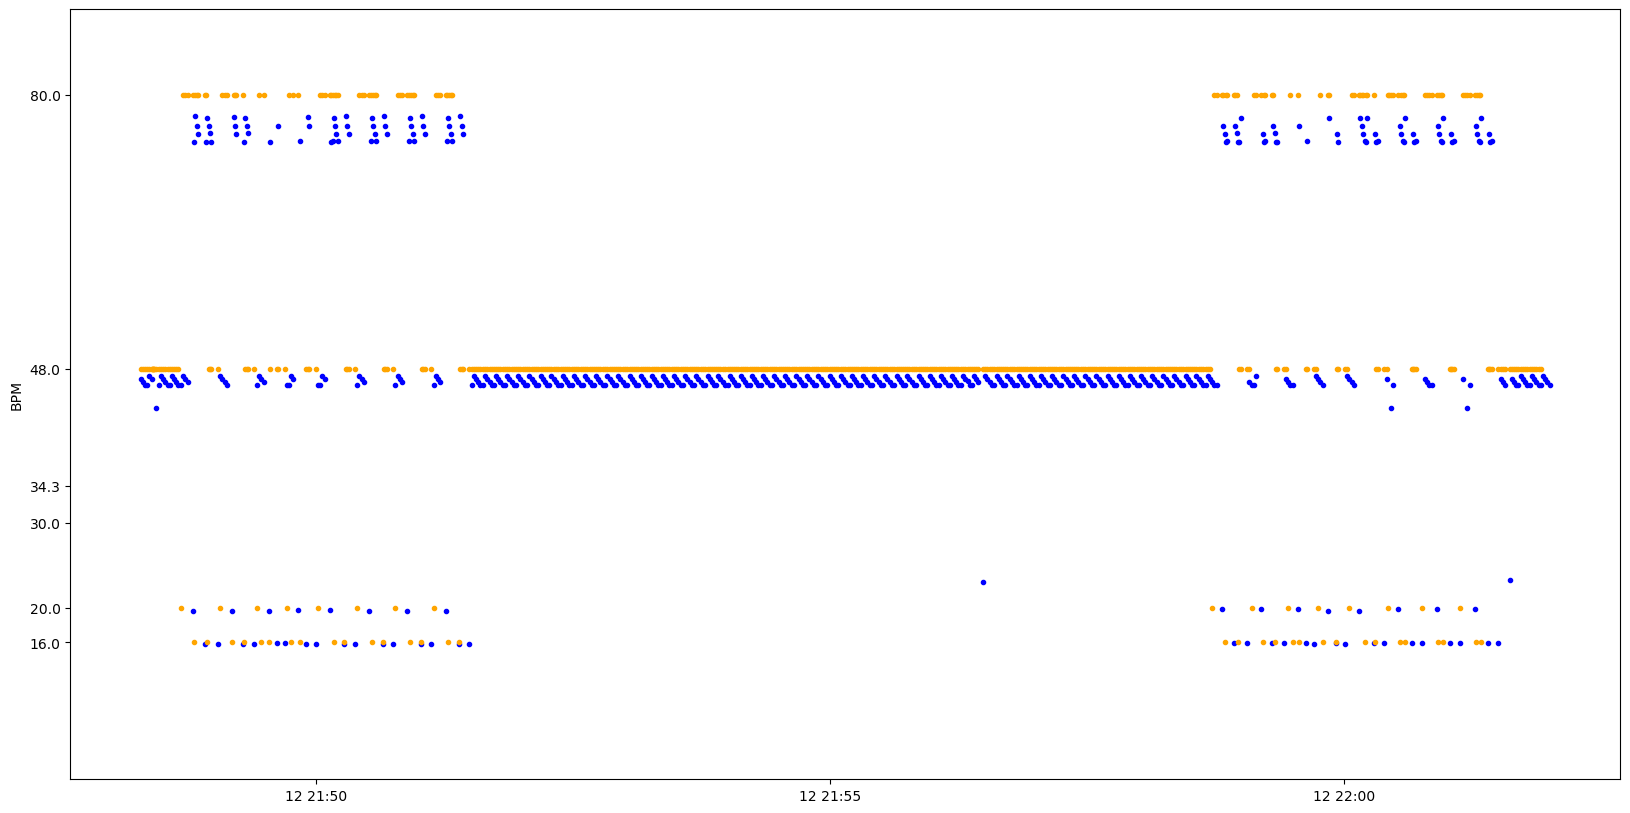

In [19]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

ax.plot(dates, bpms, label='BPMs', marker=marker, lw=linewidth, color='blue')
ax.set_ylabel("BPM")
ax.set_ylim([0, 90])
ax.set_yticks(valid_BPMs)

ax.plot(dates[:-4], normalized_BPMs, label='BPMs', marker=marker, lw=linewidth, color='orange')

ax.set_ylim([0,90])